In [1]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# !pip install imutils
import imutils
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import keras.backend as K

In [4]:
from keras.models import Model, Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, BaseLogger, EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

In [5]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

In [6]:
from keras.applications import VGG16

## Constant Variable

In [7]:
DATA_DIR = "output/"
TEST_DIR = "datasets/yzm/"
HEIGTH = 28
WIDTH = 28
CHANNEL = 1
BATCH_SIZE = 32

## Data Preprocess

In [8]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9",
               "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
               "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", 
               "U", "V", "W", "X", "Y", "Z"]

In [9]:
class DataGerenation:
    def __init__(self, data_dir, height, width, channel, class_names):
        self.data_dir = data_dir
        self.height = height
        self.width = width
        self.channel = channel
        self.class_names = class_names
        self.current_train = 0
        self.current_test = 0
        self.batch_size = BATCH_SIZE
        
    def image_preprocess(self, image):
        h, w = image.shape[:2]
        
        if w > h: 
            image = imutils.resize(image, width=self.width)
        else:
            image = imutils.resize(image, height=self.height)
        
        h_, w_ = image.shape[:2]
        pad_w = int((self.width - w_)/2)
        pad_h = int((self.height - h_)/2)
        
#         if pad_w > 0:
#             image = cv2.copyMakeBorder(image, 0, 0, pad_w, pad_w, cv2.BORDER_REPLICATE)
#         else:
#         print(pad_h, pad_h, pad_w, pad_w)
        image = cv2.copyMakeBorder(image, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REPLICATE)
        image = cv2.resize(image, (self.width, self.height))
        return image
    
    def load_image(self, image_path):
        image = cv2.imread(image_path, 0)
        image = self.image_preprocess(image)
        image = np.expand_dims(image, axis=-1)
        return image
    
    def load_image_paths(self):
        image_paths = []
        
        for cl_name in os.listdir(self.data_dir):
            if cl_name == ".DS_Store": continue
            cl_name_path = os.path.join(self.data_dir, cl_name)
            
            for img in os.listdir(cl_name_path):
                if img == ".DS_Store": continue
                img_path = os.path.join(cl_name_path, img)
                image_paths.append(img_path)
                
        return image_paths
    
    def load_data(self):
        X = []
        y = []
        current_y = 0
        image_paths = self.load_image_paths()
        
        for img_path in image_paths:
            image = self.load_image(img_path)
            label = img_path.split("/")[-2]
            X.append(image)
            y.append(label)
            
        try:
            X = np.array(X)
            y = np.array(y)
        except ValueError as e:
            print(e)
        
        return X, y
    
    def split_train_test(self):
        X, y = self.load_data()
        X, y = shuffle(X, y, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
        
        return (X_train, y_train), (X_test, y_test)
    
    def next_train(self, X, y):
        if self.current_train + 32 > X.shape[0]:
            X, y = shuffle(X, y, random_state=42)
            self.current_train = 0
        
        batch_X = X[self.current_train:self.current_train+32]
        batch_y = y[self.current_train:self.current_train+32]
        self.current_train += 32
        
        return batch_X, batch_y
    
    def next_test(self, X, y):
        if self.current_test + 32 > X.shape[0]:
            X, y = shuffle(X, y, random_state=42)
            self.current_test = 0
        
        batch_X = X[self.current_test:self.current_test+32]
        batch_y = y[self.current_test:self.current_test+32]
        self.current_test += 32
        
        return batch_X, batch_y
    
    def generate(self, X, y, s="train"):
        while True:
            if s == "train":
                batch_X, batch_y = self.next_train(X, y)
            else:
                batch_X, batch_y = self.next_test(X, y)
            
#             print(s, batch_X.shape, batch_y.shape)
                
            yield (batch_X, batch_y)

In [10]:
data_gener = DataGerenation(DATA_DIR, 28, 28, 1, class_names)

In [11]:
(X_train, y_train), (X_test, y_test) = data_gener.split_train_test()

In [12]:
X_train, X_test = X_train/255, X_test/255

In [13]:
X_train.shape, X_test.shape

((6339, 28, 28, 1), (2114, 28, 28, 1))

In [14]:
le = LabelBinarizer().fit(class_names)

In [15]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [16]:
y_train.shape

(6339, 36)

In [17]:
class_names[y_test[4].argmax()]

'0'

## Build model

In [7]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc=0.5, scale=1e-2, size=shape)

In [1]:
class FCHeadNet:
    @staticmethod
    def build(base_model, classes, D):
        head_model = base_model.output
        head_model = Flatten(name="Flatten")(head_model)
        head_model = Dense(D, activation="relu")(head_model)
        head_model = Dropout(0.5)(head_model)
        
        head_model = Dense(classes, activation="softmax")(head_model)
        return head_model

In [46]:
class MiniVGG:
    @staticmethod
    def build(height, width, channel, n_classes):
        model = Sequential()
        input_shape = (width, height, channel)
        
        if K.image_data_format == "channels_first":
            input_shape = (channel, width, height)
            
        # First conv block
        model.add(Conv2D(64, (3, 3), padding="same", 
                         input_shape=input_shape, 
                         kernel_regularizer=l2(1e-4),
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4),
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        
        #Second conv block
        model.add(Conv2D(128, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(128, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        
        #Third conv block
        model.add(Conv2D(256, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        
        #Fourth conv block
        model.add(Conv2D(512, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv2D(512, (3, 3), padding="same", 
                         kernel_regularizer=l2(1e-4), 
                         bias_initializer=initialize_bias))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.2))
        
        # Flatten
        model.add(Flatten())
        model.add(Dense(4096, kernel_regularizer=l2(1e-3)))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))
        model.add(Dense(n_classes, kernel_regularizer=l2(1e-3)))
        model.add(Activation("softmax"))
        
        return model

In [50]:
model = MiniVGG.build(28, 28, 1, len(class_names))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_25 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_33 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_26 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
activation_34 (Activation)   (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)       

In [48]:
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [49]:
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [18]:
def learning_rate_scheduler(epoch):
    initial_lr = 0.01
    F = 0.5
    D = 10
    new_lr = initial_lr * (F**np.floor((1+epoch)/D))
    
    return new_lr

In [ ]:
weight_path = "./weights"

if not os.path.exists(weight_path):
    os.mkdir(weight_path)

In [ ]:
best_weigth_path = weight_path + "/best_weight.hdf5"

In [ ]:
checkpoint = ModelCheckpoint(best_weigth_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

In [ ]:
callbacks = [LearningRateScheduler(learning_rate_scheduler), checkpoint]

In [ ]:
H = model.fit_generator(data_gener.generate(X_train, y_train), 
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test)//BATCH_SIZE,
                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                    epochs=200, callbacks=callbacks)

## Evaluation model

In [ ]:
predictions = model.predict(X_test)
print(classification_report(predictions.argmax(axis=1), y_test.argmax(axis=1), target_names=class_names))

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 200), H.history["val_loss"], label="Val Loss")
plt.plot(np.arange(0, 200), H.history["loss"], label="Train Loss")
plt.plot(np.arange(0, 200), H.history["val_accuracy"], label="Val Acc")
plt.plot(np.arange(0, 200), H.history["accuracy"], label="Train acc")
plt.title("Monitor training model")
plt.xlabel("Epoch #")
plt.ylabel("Train/Loss")
plt.legend()
plt.show()

## Prediction

In [51]:
model.load_weights("best_weight.hdf5")

In [52]:
from numpy.random import randint, choice

image_paths = os.listdir(TEST_DIR)
# image_paths

In [53]:
def image_prediction():
    idx = randint(0, len(image_paths))
    img_path = os.path.join(TEST_DIR, image_paths[idx])
    image = cv2.imread(img_path)
    plt.imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:4]
    
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)

        if w > 40:
            roi = gray[y-5:y+5+h, x-5:x + int(w/2)]
            roi_2 = gray[y-5:y+5+h, x + int(w/2):x+5+int(w/2)]
#             plt.imshow(roi)
            roi = data_gener.image_preprocess(roi)
            roi = np.expand_dims(roi, axis=-1)
            roi_2 = data_gener.image_preprocess(roi_2)
            roi_2 = np.expand_dims(roi_2, axis=-1)
            rois = np.array([roi, roi_2])
        else:
            roi = gray[y-5:y+5+h, x-5:x+5+w]
#             plt.imshow(roi)
            roi = data_gener.image_preprocess(roi)
            roi = np.expand_dims(roi, axis=-1)
            rois = np.array([roi])

        for roi in rois:    
            prediction = model.predict(roi.reshape(1, 28, 28, 1))
#             print(prediction)
            print(le.classes_[prediction.argmax(axis=1)[0]])
                
#     plt.imshow(thresh, cmap="gray")

H
H
H
H


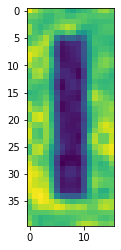

In [54]:
image_prediction()